In [1]:
!pip install networkx[default]
!!pip install adjustText

['Collecting adjustText',
 '  Downloading adjustText-1.2.0-py3-none-any.whl.metadata (3.0 kB)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from adjustText) (1.26.4)',
 'Requirement already satisfied: matplotlib in /usr/local/lib/python3.10/dist-packages (from adjustText) (3.7.1)',
 'Requirement already satisfied: scipy in /usr/local/lib/python3.10/dist-packages (from adjustText) (1.13.1)',
 'Requirement already satisfied: contourpy>=1.0.1 in /usr/local/lib/python3.10/dist-packages (from matplotlib->adjustText) (1.3.0)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.10/dist-packages (from matplotlib->adjustText) (0.12.1)',
 'Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.10/dist-packages (from matplotlib->adjustText) (4.53.1)',
 'Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.10/dist-packages (from matplotlib->adjustText) (1.4.7)',
 'Requirement already satisfied: pa

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "CLL_Phd"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/CLL_Phd


In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import re
import os
import pandas as pd
import networkx as nx
import gc
from adjustText import adjust_text

In [5]:
gc.collect()

# Biological priors with learning weights after supervised clustering
file_path = "ICGC/sc1_weights_go_BCMO.xlsx"
correlation_matrix = pd.read_excel(file_path, engine='openpyxl', index_col=0)
### data pre-processing to obtain the actual sc1_weights_fixed_MGH_Mayo

data = []


for pathway, series in correlation_matrix.iterrows():
    for gene, value in series.items():
        data.append([pathway, gene, value])

# PASNet outputs (source:pathway; target:protein; Weight:learning weights from PASNet)
df_go = pd.DataFrame(data, columns=['source', 'target', 'Weight'])
df_go = df_go[df_go['Weight'] != 0]
df_go = df_go[(df_go['Weight'] > 0.5) | (df_go['Weight'] < -0.5)]

# Biological priors with learning weights after supervised clustering
file_path = "ICGC/sc1_weights_rest_BCMO.xlsx"
correlation_matrix = pd.read_excel(file_path, engine='openpyxl', index_col=0)
### data pre-processing to obtain the actual sc1_weights_fixed_MGH_Mayo

data = []


for pathway, series in correlation_matrix.iterrows():
    for gene, value in series.items():
        data.append([pathway, gene, value])

# PASNet outputs (source:pathway; target:protein; Weight:learning weights from PASNet)
df_rest = pd.DataFrame(data, columns=['source', 'target', 'Weight'])
df_rest = df_rest[df_rest['Weight'] != 0]
df_rest = df_rest[(df_rest['Weight'] > 0.3) | (df_rest['Weight'] < -0.3)]

df = pd.concat([df_go, df_rest], ignore_index=True)

#Harmonizing with the SJARACNe file format that is to follow
genes_list = pd.concat([df['source'], df['target']]).unique().tolist()

df['MI'] = None
df['spearman'] = None
df['p-value'] = None

In [6]:
df_sj_sig = pd.read_csv("ICGC/consensus_network_ncol_sig.txt", sep='\t')
df_sj_tf = pd.read_csv("ICGC/consensus_network_ncol_tf.txt", sep='\t')
df_sj_nc = pd.read_csv("ICGC/consensus_network_ncol_nc.txt", sep='\t')

# Row binding the two dataframes
df_sj = pd.concat([df_sj_sig, df_sj_tf, df_sj_nc], axis=0, ignore_index=True)

# Removing duplicates based on columns "source" and "target"
df_sj = df_sj.drop_duplicates(subset=['source', 'target'])

#df_sj = df_sj[df_sj['source'].isin(genes_list) | df_sj['target'].isin(genes_list)]

# Keep only the specified columns: source, label, MI, spearman, p-value
columns_to_keep = ['source', 'target', 'MI', 'spearman', 'p-value']
df_sj = df_sj[columns_to_keep]

#Harmonizing with PASNet outputs
df_sj['Weight'] = None
df_sj = df_sj[df_sj['p-value'] <= 0.05]

## Combine with PASNet outputs

combined_df = pd.concat([df, df_sj], ignore_index=True)

<ipython-input-6-055ca1ee1795>:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, df_sj], ignore_index=True)


In [7]:
node_attr_genes = pd.read_excel("ICGC/results.xlsx")

genes_SHAP = [
    "ATP6V0C", "ZAP70", "LPL", "GAB1", "ZNF318", "DUSP1", "SLC23A1", "KLK2",
    "SLC4A7", "TBXT", "CAV1", "AGPAT4", "TERT", "GCM1", "FOXJ1", "PLD1",
    "WRNIP1", "MORC3", "RCOR2", "MYLK", "GRK3", "USP18", "FLNB", "LTBR",
    "PRPS2", "MAPK4", "NOD2", "DPYD", "RASAL1", "ZNF471", "MIR4458HG",
    "PIWIL4", "KCNK9", "KCNJ2-AS1", "KSR2", "TP63"
]

node_attr_genes = node_attr_genes[node_attr_genes['ID'].isin(genes_SHAP)]

weights = df['source'].unique()
weights_df = pd.DataFrame({
    'ID': weights,
    'funcType': "Pathway",
    'Size': np.nan,
    'logFC_DA': np.nan,
    'adj_pval_DA': np.nan,
    'logFC_DE': np.nan,
    'adj_pval_DE': np.nan,
})

node_combined = pd.concat([node_attr_genes, weights_df], ignore_index=True)
len(node_combined)

228

In [8]:
# Step 1: Read the DataFrame with the edge connections
df_edges = combined_df

# Step 2: Read the DataFrame with node attributes
df_node_attributes = node_combined

df_edges = df_edges[df_edges['source'].isin(df_node_attributes['ID']) & df_edges['target'].isin(df_node_attributes['ID'])]

# Step 3: Create a undirected graph
G_shap = nx.Graph()

# Step 4: Add edges to the graph
for index, row in df_edges.iterrows():
    source = row['source']
    target = row['target']
    attributes = row.drop(['source', 'target'])  # Extract edge attributes
    G_shap.add_edge(source, target, **attributes)  # Add edge with attributes

# Step 5: Transfer node attributes
for index, row in df_node_attributes.iterrows():
    node_name = row['ID']
    if node_name in G_shap.nodes:
        attributes = row.drop('ID')  # Remove the node name to keep only the attributes
        G_shap.nodes[node_name].update(attributes)

# Add a new attribute 'label' with node names
for node in G_shap.nodes:
    G_shap.nodes[node]['label'] = str(node)  # Set 'label' attribute to node name (convert to string if needed)

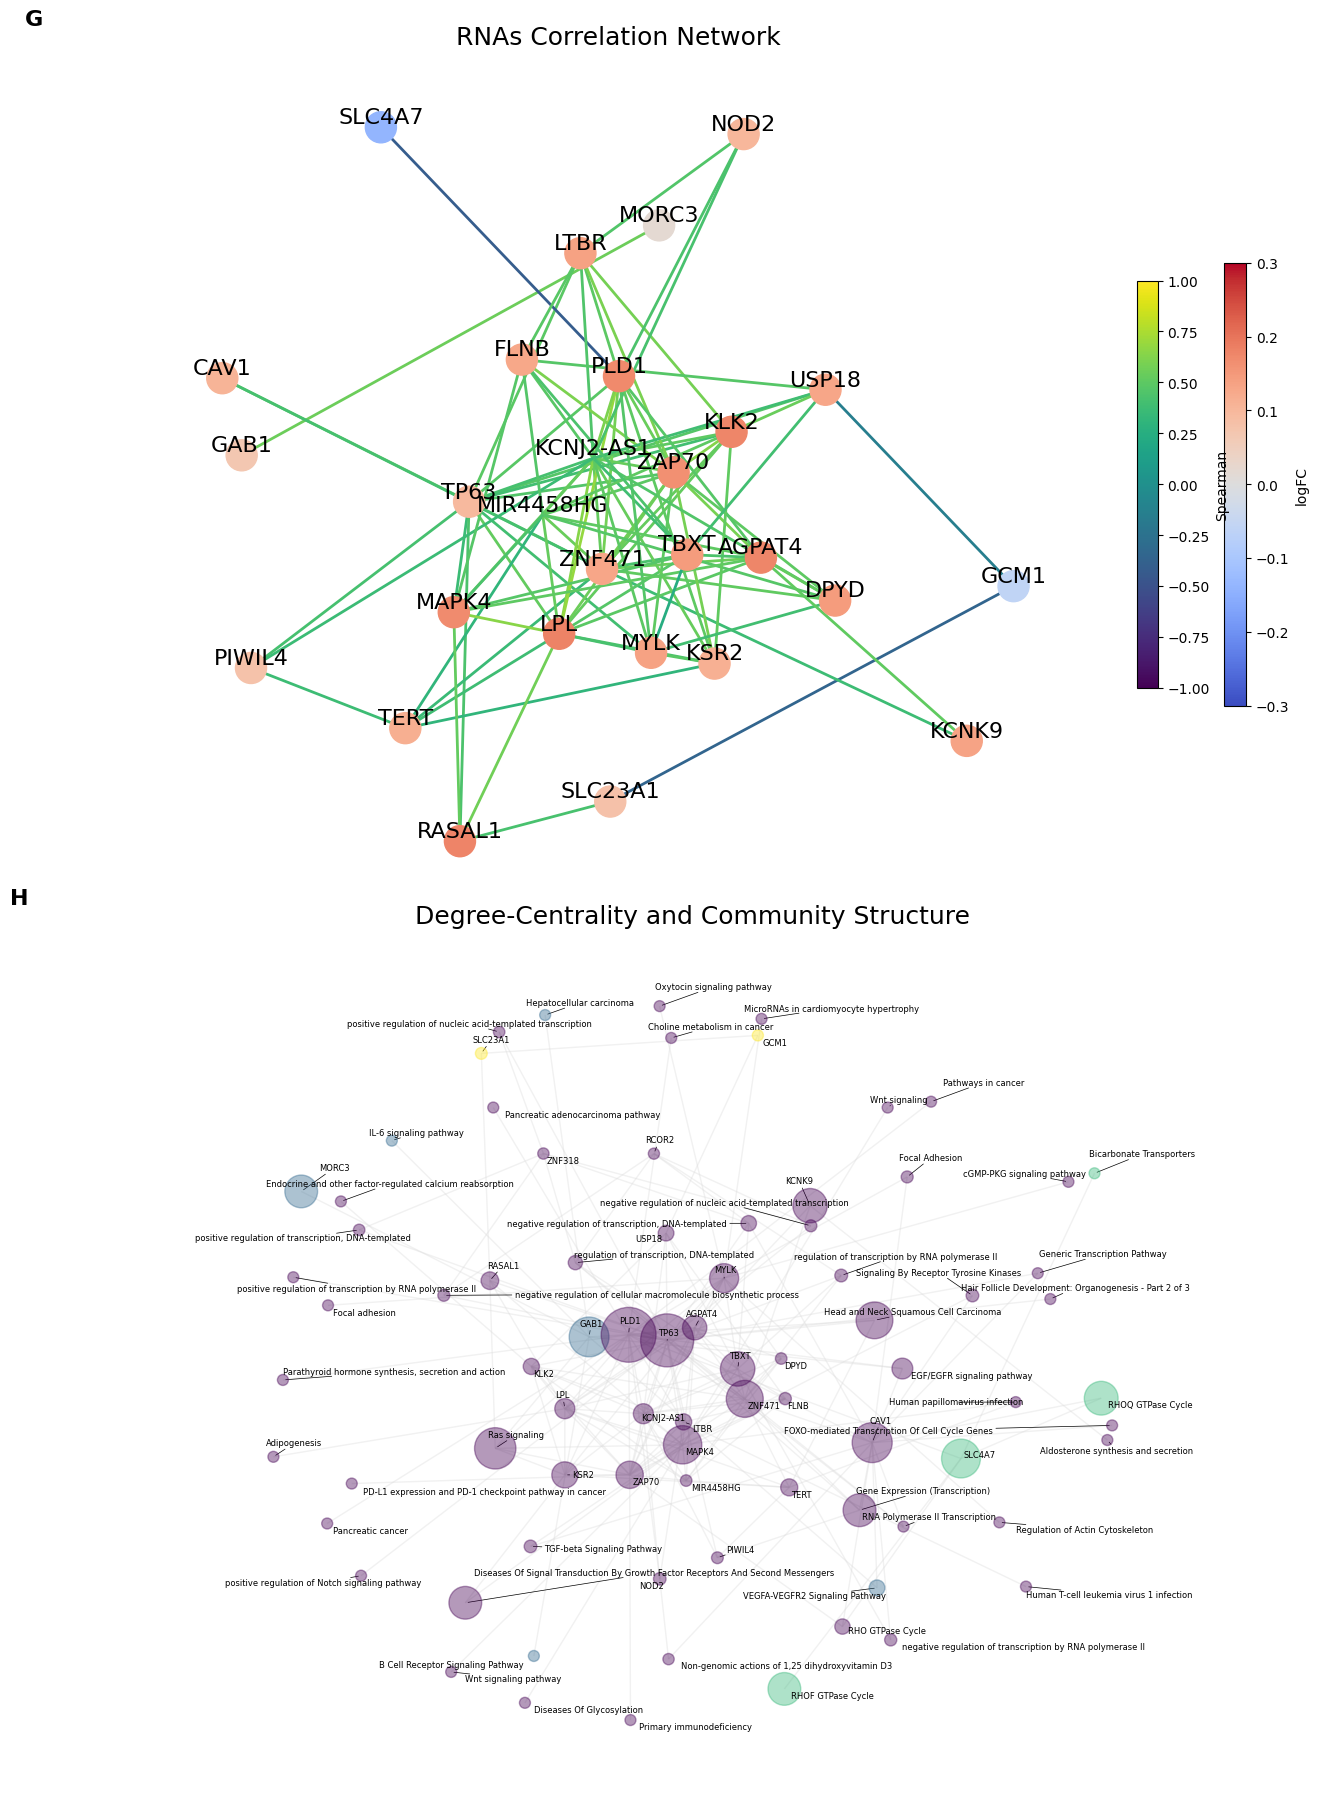

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from adjustText import adjust_text
import re  # Import re for regular expression operations

# Create the 1x2 subplot grid
fig, axs = plt.subplots(2, 1, figsize=(12, 18))
axs = axs.flatten()  # Flatten the array of axes for easy indexing

# Panel G: RNA Correlation Network
G = G_shap
genes = genes_SHAP

# Filter the graph by the list of genes
G3 = G.subgraph(genes).copy()

# Remove unconnected nodes (isolates)
isolates = list(nx.isolates(G3))
G3.remove_nodes_from(isolates)

# Compute layout for visualization
pos = nx.spring_layout(G3, seed=1250, k=1)  # Adjust 'k' for spacing

# Define color maps
cmap_logFC = plt.get_cmap('coolwarm')
cmap_spearman = plt.get_cmap('viridis')
cmap_weight = plt.get_cmap('viridis')

# Normalize functions for color mapping
norm_logFC = mcolors.Normalize(vmin=-0.3, vmax=0.3)
norm_spearman = mcolors.Normalize(vmin=-1, vmax=1)
norm_weight = mcolors.Normalize(vmin=0, vmax=1)

# Create node attributes
node_colors = []
node_shapes = []
node_sizes = []

for node in G3.nodes(data=True):
    if node[1]['funcType'] == 'Pathway':
        node_colors.append('green')
        node_shapes.append('o')  # Circle for Pathway
        node_sizes.append(500)
    else:
        if node[1]['logFC_DA'] is not None:
            node_colors.append(cmap_logFC(norm_logFC(node[1]['logFC_DA'])))
        else:
            node_colors.append('lightgray')

        if node[1]['funcType'] == 'SIG':
            node_shapes.append('o')
            node_sizes.append(500)
        elif node[1]['funcType'] == 'TF':
            node_shapes.append('o')
            node_sizes.append(500)
        elif node[1]['funcType'] == 'NC':
            node_shapes.append('D')
            node_sizes.append(2000)
        else:
            node_shapes.append('o')
            node_sizes.append(500)

# Create edge attributes
edge_colors = []
for u, v, data in G3.edges(data=True):
    funcType_u = G3.nodes[u]['funcType']
    funcType_v = G3.nodes[v]['funcType']

    if funcType_u in ['SIG', 'TF', 'NC'] and funcType_v in ['SIG', 'TF', 'NC']:
        edge_colors.append(cmap_spearman(norm_spearman(data.get('spearman', 0))))
    elif (funcType_u == 'Pathway' or funcType_v == 'Pathway') and \
         (funcType_u in ['SIG', 'TF', 'NC'] or funcType_v in ['SIG', 'TF', 'NC']):
        edge_colors.append(cmap_weight(norm_weight(data.get('Weight', 0))))
    else:
        edge_colors.append('lightgray')

# Plot the network for panel G
nx.draw_networkx_nodes(
    G3,
    pos,
    nodelist=[n for n, s in zip(G3.nodes, node_shapes) if s == shape],
    node_size=[node_sizes[i] for i, s in enumerate(node_shapes) if s == shape],
    node_color=[node_colors[i] for i, s in enumerate(node_shapes) if s == shape],
    node_shape=shape,
    label=f'{shape} type',
    ax=axs[0]
)
sm_logFC = plt.cm.ScalarMappable(cmap=cmap_logFC, norm=plt.Normalize(vmin=-0.3, vmax=0.3))
cbar_logFC = plt.colorbar(sm_logFC, ax=axs[0], fraction=0.02, pad=0.06)
cbar_logFC.set_label('logFC')

sm_spearman = plt.cm.ScalarMappable(cmap=cmap_spearman, norm=plt.Normalize(vmin=-1, vmax=1))
cbar_spearman = plt.colorbar(sm_spearman, ax=axs[0], fraction=0.02, pad=0.04)
cbar_spearman.set_label('Spearman')

nx.draw_networkx_edges(
    G3,
    pos,
    edge_color=edge_colors,
    width=2,
    ax=axs[0]
)
nx.draw_networkx_labels(
    G3,
    pos,
    font_size=16,
    font_family='sans-serif',
    verticalalignment='bottom',
    ax=axs[0]
)

axs[0].set_title('RNAs Correlation Network', fontsize=18)
axs[0].axis('off')

# Panel H: Degree-Centrality and Community Structure
F = G_shap
components = nx.connected_components(F)
largest_component = max(components, key=len)
F = F.subgraph(largest_component)

# Compute centrality
centrality = nx.betweenness_centrality(F, k=10, endpoints=True)

# Compute community structure
lpc = nx.community.label_propagation_communities(F)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

def clean_label(label):
    patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
    for pattern in patterns:
        label = re.sub(pattern, '', label)
    return label.strip()

cleaned_labels = {node: clean_label(node) for node in F.nodes()}

pos = nx.spring_layout(F, k=0.7, seed=1400)

# Draw the network for panel H
node_color = [community_index[n] for n in F]
node_size = [v * 5000 for v in centrality.values()]

nx.draw_networkx_nodes(
    F,
    pos=pos,
    node_color=node_color,
    node_size=node_size,
    alpha=0.4,
    ax=axs[1]
)
nx.draw_networkx_edges(
    F,
    pos=pos,
    edge_color="gainsboro",
    alpha=0.4,
    ax=axs[1]
)

texts = []
for node, label in cleaned_labels.items():
    x, y = pos[node]
    text = axs[1].text(x, y, label, fontsize=6, ha='center', va='center')
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

axs[1].margins(0.1, 0.05)

fig.tight_layout()
axs[1].axis('off')

axs[1].set_title('Degree-Centrality and Community Structure', fontsize=18)

# Add panel labels
panel_labels = ['G', 'H']
for ax, label in zip(axs, panel_labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold',
            va='top', ha='right')

# Save and show the final figure
plt.savefig('multipanel_figure.png', format='png', dpi=600)
plt.show()
